In [1]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from ebm.model import Network
import networkx as nx
from ebm.external_world import ExternalWorld, MNISTExternalWorld

from ebm.train_model import *


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



In [2]:
import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

def draw_energy_graph_3d(net, sample_idx, x_gap=8.0, y_gap=5.0, z_scale=300.0):
    def compute_layout_2d(layer_sizes):
        pos = {}
        for i, size in enumerate(layer_sizes):
            offset = (size - 1) * y_gap / 2
            for j in range(size):
                jitter = 0.3 if j % 2 == 0 else -0.3
                pos[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
        return pos

    def compute_node_energies(net, sample_idx):
        activations = [layer[sample_idx] for layer in net.layers]
        biases = net.biases
        weights = net.weights
        node_energy = {}
        for i in range(len(activations)):
            for j in range(len(activations[i])):
                a = activations[i][j].item()
                b = biases[i][j].item()
                node_energy[(i, j)] = -b * a if i > 0 else 0.0
        for idx, W in enumerate(weights):
            a_src = activations[idx]
            a_tgt = activations[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    contrib = -a_src[i].item() * W[i, j].item() * a_tgt[j].item()
                    node_energy[(idx, i)] += 0.5 * contrib
                    node_energy[(idx + 1, j)] += 0.5 * contrib
        return node_energy

    def build_energy_graph(net, sample_idx):
        G = nx.DiGraph()
        acts = [layer[sample_idx] for layer in net.layers]
        parts = [p[sample_idx] for p in net.persistent_particles]
        y = net.y_data[sample_idx].item()
        node_energy = compute_node_energies(net, sample_idx)
        layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
        labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
        for i, size in enumerate(layer_sizes):
            for j in range(size):
                a = acts[i][j].item()
                b = net.biases[i][j].item()
                post = a + b if i > 0 else a
                p = parts[i - 1][j].item() if i > 0 else 0.0
                out = a if i == len(layer_sizes) - 1 else None
                label = f"{labels[i]} {j}\nPre={a:.2f} Bias={b:.2f}\nPost={post:.2f}"
                if out is not None:
                    label += f"\nŷ={out:.2f} y={y}"
                G.add_node((i, j), activation=a, bias=b, label=label, particle=p, energy=node_energy[(i, j)], layer=i)
        for idx, W in enumerate(net.weights):
            a_src = acts[idx]
            a_tgt = acts[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    w = W[i, j].item()
                    contrib = -a_src[i].item() * w * a_tgt[j].item()
                    G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=f"{w:.2f}\nΔE={contrib:.2f}")
        return G, layer_sizes

    def draw_layer_planes(ax, x_vals, zmin, zmax):
        for x in x_vals:
            ax.plot_surface(
                np.array([[x, x], [x, x]]),
                np.array([[-20, 20], [-20, 20]]),
                np.array([[zmin, zmin], [zmax, zmax]]),
                color='gray', alpha=0.06, zorder=-1
            )

    # def draw_energy_contours(ax, z_levels, x_range, y_range):
    #     for z in z_levels:
    #         ax.plot_surface(
    #             np.array([[x_range[0], x_range[1]], [x_range[0], x_range[1]]]),
    #             np.array([[y_range[0], y_range[0]], [y_range[1], y_range[1]]]),
    #             np.array([[z, z], [z, z]]),
    #             color='gray', alpha=0.05, zorder=-1
    #         )

    def set_axes_equal_3d(ax):
        xlim = ax.get_xlim3d()
        ylim = ax.get_ylim3d()
        zlim = ax.get_zlim3d()
        max_range = max(
            abs(xlim[1] - xlim[0]),
            abs(ylim[1] - ylim[0]),
            abs(zlim[1] - zlim[0])
        )
        for lim_setter, center in zip(
            [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d],
            [(xlim[0]+xlim[1])/2, (ylim[0]+ylim[1])/2, (zlim[0]+zlim[1])/2]
        ):
            lim_setter([center - max_range/2, center + max_range/2])

    def get_node_style(i, total_layers):
        if i == 0:
            return {'marker': 's', 'facecolor': 'skyblue'}
        elif i == total_layers - 1:
            return {'marker': '^', 'facecolor': 'salmon'}
        else:
            return {'marker': 'o', 'facecolor': 'lightgray'}

    # === Main logic ===
    G, layer_sizes = build_energy_graph(net, sample_idx)
    total_layers = len(layer_sizes)
    pos2d = compute_layout_2d(layer_sizes)
    energies = [G.nodes[n]['energy'] for n in G.nodes()]
    zs = [e * z_scale for e in energies]
    edge_contribs = [G.edges[e]['contrib'] for e in G.edges()]
    norm_edge = mcolors.Normalize(vmin=-max(map(abs, edge_contribs)), vmax=max(map(abs, edge_contribs)))
    cmap_edge = cm.coolwarm
    cmap_particle = cm.PuBu

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=-70)

    # === Planes ===
    x_vals = sorted(set(pos2d[n][0] for n in G.nodes()))
    draw_layer_planes(ax, x_vals, zmin=min(zs)-4, zmax=max(zs)+4)
    # draw_energy_contours(ax,
    #                      z_levels=np.linspace(min(zs), max(zs), 8),
    #                      x_range=(min(x_vals)-4, max(x_vals)+4),
    #                      y_range=(-20, 20))

    # === Draw nodes ===
    for (i, j) in G.nodes():
        x, y = pos2d[(i, j)]
        z = G.nodes[(i, j)]['energy'] * z_scale
        p = G.nodes[(i, j)]['particle']
        label = G.nodes[(i, j)]['label']
        style = get_node_style(i, total_layers)
        particle_color = cmap_particle((p + 1) / 2)
        ax.scatter([x], [y], [z], s=180, marker=style['marker'],
                   color=style['facecolor'], edgecolors='black', zorder=3)
        ax.text(x, y, z + 0.5, label, fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=0.8))

    # === Draw edges ===
    for u, v in G.edges():
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = G.nodes[u]['energy'] * z_scale
        z1 = G.nodes[v]['energy'] * z_scale
        c = G.edges[(u, v)]['contrib']
        label = G.edges[(u, v)]['label']
        color = cmap_edge(norm_edge(c))
        ax.plot([x0, x1], [y0, y1], [z0, z1], color=color, linewidth=2.2, alpha=0.9)
        ax.text((x0+x1)/2, (y0+y1)/2, (z0+z1)/2 + 0.3, label, fontsize=6,
                ha='center', bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    # === Labels, limits, scaling ===
    for i in range(total_layers):
        ax.text(i * x_gap, 0, max(zs) + 2.5, f"Layer {i}", ha='center', fontsize=9, weight='bold')

    ax.set_xlabel("Layer (x)")
    ax.set_ylabel("Position (y)")
    ax.set_zlabel("Energy (z)")
    ax.set_title(f"Sample {sample_idx} | Total Energy = {sum(energies):.4f}")

    # === Absolute limits to avoid autoscaling squash ===
    xs = [pos2d[n][0] for n in G.nodes()]
    ys = [pos2d[n][1] for n in G.nodes()]
    ax.set_xlim(min(xs) - 4, max(xs) + 4)
    ax.set_ylim(min(ys) - 4, max(ys) + 4)
    ax.set_zlim(min(zs) - 4, max(zs) + 4)
    set_axes_equal_3d(ax)

    plt.tight_layout()
    plt.show()


In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D

def draw_energy_graph_3d(net, sample_idx, x_gap=8.0, y_gap=5.0, z_scale=300.0, n_curve_pts=20):
    def compute_layout_2d(layer_sizes):
        pos = {}
        for i, size in enumerate(layer_sizes):
            offset = (size - 1) * y_gap / 2
            for j in range(size):
                jitter = 0.3 if j % 2 == 0 else -0.3
                pos[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
        return pos

    def compute_node_energies(net, sample_idx):
        activations = [layer[sample_idx] for layer in net.layers]
        biases = net.biases
        weights = net.weights
        node_energy = {}
        for i in range(len(activations)):
            for j in range(len(activations[i])):
                a = activations[i][j].item()
                b = biases[i][j].item()
                node_energy[(i, j)] = -b * a if i > 0 else 0.0
        for idx, W in enumerate(weights):
            a_src = activations[idx]
            a_tgt = activations[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    contrib = -a_src[i].item() * W[i, j].item() * a_tgt[j].item()
                    node_energy[(idx, i)] += 0.5 * contrib
                    node_energy[(idx + 1, j)] += 0.5 * contrib
        return node_energy

    def build_energy_graph(net, sample_idx):
        G = nx.DiGraph()
        acts = [layer[sample_idx] for layer in net.layers]
        parts = [p[sample_idx] for p in net.persistent_particles]
        y = net.y_data[sample_idx].item()
        node_energy = compute_node_energies(net, sample_idx)
        layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
        labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
        for i, size in enumerate(layer_sizes):
            for j in range(size):
                a = acts[i][j].item()
                b = net.biases[i][j].item()
                post = a + b if i > 0 else a
                p = parts[i - 1][j].item() if i > 0 else 0.0
                out = a if i == len(layer_sizes) - 1 else None
                label = f"{labels[i]} {j}\nPre={a:.2f} Bias={b:.2f}\nPost={post:.2f}"
                if out is not None:
                    label += f"\nŷ={out:.2f} y={y}"
                G.add_node((i, j), activation=a, bias=b, label=label, particle=p, energy=node_energy[(i, j)], layer=i)
        for idx, W in enumerate(net.weights):
            a_src = acts[idx]
            a_tgt = acts[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    w = W[i, j].item()
                    contrib = -a_src[i].item() * w * a_tgt[j].item()
                    G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=f"{w:.2f}\nΔE={contrib:.2f}")
        return G, layer_sizes

    def draw_layer_planes(ax, x_vals, zmin, zmax):
        for x in x_vals:
            ax.plot_surface(
                np.array([[x, x], [x, x]]),
                np.array([[-20, 20], [-20, 20]]),
                np.array([[zmin, zmin], [zmax, zmax]]),
                color='gray', alpha=0.06, zorder=-1
            )

    def set_axes_equal_3d(ax):
        xlim, ylim, zlim = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
        max_range = max(
            abs(xlim[1] - xlim[0]),
            abs(ylim[1] - ylim[0]),
            abs(zlim[1] - zlim[0])
        )
        for lim_setter, center in zip(
            [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d],
            [(xlim[0]+xlim[1])/2, (ylim[0]+ylim[1])/2, (zlim[0]+zlim[1])/2]
        ):
            lim_setter([center - max_range/2, center + max_range/2])

    def get_node_style(i, total_layers):
        if i == 0: return {'marker': 's', 'facecolor': 'skyblue'}
        elif i == total_layers - 1: return {'marker': '^', 'facecolor': 'salmon'}
        else: return {'marker': 'o', 'facecolor': 'lightgray'}

    def bezier_curve(p0, p1, mid_z, n_points=20):
        """Return n-point quadratic Bézier curve between p0 and p1 arching toward mid_z"""
        p0, p1 = np.array(p0), np.array(p1)
        midpoint = (p0 + p1) / 2
        control = np.array([midpoint[0], midpoint[1], mid_z])
        t = np.linspace(0, 1, n_points)[:, None]
        curve = (1 - t) ** 2 * p0 + 2 * (1 - t) * t * control + t ** 2 * p1
        return curve

    # === Main ===
    G, layer_sizes = build_energy_graph(net, sample_idx)
    total_layers = len(layer_sizes)
    pos2d = compute_layout_2d(layer_sizes)
    energies = [G.nodes[n]['energy'] for n in G.nodes()]
    zs = [e * z_scale for e in energies]
    edge_contribs = [G.edges[e]['contrib'] for e in G.edges()]
    norm_edge = mcolors.Normalize(vmin=-max(map(abs, edge_contribs)), vmax=max(map(abs, edge_contribs)))
    cmap_edge = cm.coolwarm
    cmap_particle = cm.PuBu

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=-70)

    x_vals = sorted(set(pos2d[n][0] for n in G.nodes()))
    draw_layer_planes(ax, x_vals, zmin=min(zs)-4, zmax=max(zs)+4)

    # === Node arrows ===
    for (i, j) in G.nodes():
        x, y = pos2d[(i, j)]
        a = G.nodes[(i, j)]['activation']
        b = G.nodes[(i, j)]['bias']
        pre_z = a * z_scale
        post_z = (a + b) * z_scale if i > 0 else a * z_scale
        dz = post_z - pre_z

        label = G.nodes[(i, j)]['label']
        style = get_node_style(i, total_layers)
        p = G.nodes[(i, j)]['particle']
        particle_color = cmap_particle((p + 1) / 2)

        ax.quiver(x, y, pre_z, 0, 0, dz, arrow_length_ratio=0.1,
                  color=style['facecolor'], linewidth=1.5, edgecolor='black')
        ax.text(x, y, post_z + 0.5, label, fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=0.8))

    # === Curved energy-decreasing edges ===
    for u, v in G.edges():
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = G.nodes[u]['energy'] * z_scale
        z1 = G.nodes[v]['energy'] * z_scale
        c = G.edges[(u, v)]['contrib']
        label = G.edges[(u, v)]['label']
        color = cmap_edge(norm_edge(c))

        # Draw curve pulling toward lower energy
        p0 = (x0, y0, z0)
        p1 = (x1, y1, z1)
        mid_z = min(z0, z1) - 0.3 * abs(z1 - z0) - 3  # bend downward more for bigger ΔE

        curve = bezier_curve(p0, p1, mid_z, n_points=n_curve_pts)
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], color=color, linewidth=2.2, alpha=0.9)

        label_z = curve[n_curve_pts // 2, 2]
        ax.text((x0+x1)/2, (y0+y1)/2, label_z + 0.3, label, fontsize=6,
                ha='center', bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    # === Labels and scaling ===
    for i in range(total_layers):
        ax.text(i * x_gap, 0, max(zs) + 2.5, f"Layer {i}", ha='center', fontsize=9, weight='bold')

    ax.set_xlabel("Layer (x)")
    ax.set_ylabel("Position (y)")
    ax.set_zlabel("Energy (z)")
    ax.set_title(f"Sample {sample_idx} | Total Energy = {sum(energies):.4f}")

    xs = [pos2d[n][0] for n in G.nodes()]
    ys = [pos2d[n][1] for n in G.nodes()]
    ax.set_xlim(min(xs) - 4, max(xs) + 4)
    ax.set_ylim(min(ys) - 4, max(ys) + 4)
    ax.set_zlim(min(zs) - 4, max(zs) + 4)
    set_axes_equal_3d(ax)

    plt.tight_layout()
    plt.show()


In [93]:
import networkx as nx

def build_energy_graph(net, sample_idx):
    G = nx.DiGraph()

    # Gather relevant per-sample info
    activations = [layer[sample_idx] for layer in net.layers]
    particles = [p[sample_idx] for p in net.persistent_particles]
    y_label = net.y_data[sample_idx].item()
    weights = net.weights
    biases = net.biases

    # Layer sizes
    layer_sizes = [weights[0].shape[0]] + [W.shape[1] for W in weights]
    labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    # === Compute energy at each node ===
    node_energy = {}
    for i, act in enumerate(activations):
        for j in range(len(act)):
            a = act[j].item()
            b = biases[i][j].item()
            e = -b * a if i > 0 else 0.0  # input layer has no bias
            node_energy[(i, j)] = e

    # === Add pairwise energy contributions to node energies ===
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                node_energy[(l, i)] += 0.5 * contrib
                node_energy[(l + 1, j)] += 0.5 * contrib

    # === Add nodes to the graph ===
    for i, size in enumerate(layer_sizes):
        for j in range(size):
            a = activations[i][j].item()
            b = biases[i][j].item()
            post = a + b if i > 0 else a
            p = particles[i - 1][j].item() if i > 0 else 0.0
            out = a if i == len(layer_sizes) - 1 else None

            label = f"{labels[i]} {j}\nPre={a:.2f} Bias={b:.2f}\nPost={post:.2f}"
            if out is not None:
                label += f"\nŷ={out:.2f} y={y_label}"

            G.add_node(
                (i, j),
                activation=a,
                bias=b,
                post=post,
                particle=p,
                energy=node_energy[(i, j)],
                label=label,
                layer=i,
            )

    # === Add edges to the graph ===
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                G.add_edge(
                    (l, i),
                    (l + 1, j),
                    weight=w,
                    contrib=contrib,
                    label=f"{w:.2f}\nΔE={contrib:.2f}"
                )

    return G, layer_sizes


In [94]:
import matplotlib.colors as mcolors

def prepare_visual_layout(G, layer_sizes, x_gap=None, y_gap=None, z_scale=None, extent=40.0):
    pos2d = {}
    layer_xs = []

    # === Normalize x per layer ===
    n_layers = len(layer_sizes)
    x_norm = [i / (n_layers - 1) if n_layers > 1 else 0.5 for i in range(n_layers)]

    # === Build normalized (x, y) positions ===
    for i, size in enumerate(layer_sizes):
        x = x_norm[i] * extent
        layer_xs.append(x)
        y_vals = [(j / (size - 1) if size > 1 else 0.5) for j in range(size)]
        for j, y_norm in enumerate(y_vals):
            y = (1 - y_norm) * extent  # top-to-bottom
            pos2d[(i, j)] = (x, y)

    # === Energy-based z + post-bias z
    z = {}
    post_bias_zs = []
    raw_energies = []

    for n in G.nodes():
        a = G.nodes[n]['activation']
        b = G.nodes[n]['bias']
        e = G.nodes[n]['energy']
        raw_energies.append(e)
        post_val = a + b if G.nodes[n]['layer'] > 0 else a
        post_bias_zs.append(post_val)

    # Normalize z across all values
    all_z_vals = raw_energies + post_bias_zs
    z_min_raw, z_max_raw = min(all_z_vals), max(all_z_vals)
    z_range = z_max_raw - z_min_raw + 1e-6
    z_scale = extent / z_range  # stretch to match x/y scale

    # Compute final z values
    for n in G.nodes():
        z[n] = (G.nodes[n]['energy'] - z_min_raw) * z_scale
    z_min, z_max = min(z.values()), max(z.values())

    # === Normalize edge contributions
    edge_contribs = [G.edges[e]['contrib'] for e in G.edges()]
    contrib_max = max(abs(c) for c in edge_contribs) if edge_contribs else 1.0
    edge_contrib_norm = mcolors.Normalize(vmin=-contrib_max, vmax=contrib_max)

    return {
        'pos2d': pos2d,
        'z': z,
        'z_min': z_min,
        'z_max': z_max,
        'z_scale': z_scale,
        'edge_contribs': edge_contribs,
        'color_norms': {
            'edge': edge_contrib_norm,
        },
        'layer_xs': layer_xs,
    }


In [115]:
def draw_nodes(ax, G, layout_info, z_scale, cmap_particle, arrow_boost=5.0):
    pos2d = layout_info['pos2d']
    z_vals = layout_info['z']
    total_layers = max(i for (i, _) in G.nodes()) + 1

    def get_marker_style(i):
        if i == 0:
            return {'marker': 's', 'color': 'skyblue'}     # Input
        elif i == total_layers - 1:
            return {'marker': '^', 'color': 'salmon'}       # Output
        else:
            return {'marker': 'o', 'color': 'lightgray'}    # Hidden

    for (i, j) in G.nodes():
        x, y = pos2d[(i, j)]
        a = G.nodes[(i, j)]['activation']
        b = G.nodes[(i, j)]['bias']
        post = G.nodes[(i, j)]['post']
        pre_z = a * z_scale
        post_z = post * z_scale
        dz = post_z - pre_z
        dz_vis = dz * arrow_boost

        label = G.nodes[(i, j)]['label']
        particle = G.nodes[(i, j)]['particle']
        style = get_marker_style(i)
        particle_color = cmap_particle((particle + 1) / 2)

        # Always draw the dot at post_z
        ax.scatter([x], [y], [post_z], s=100, marker=style['marker'],
                   color=style['color'], edgecolors='black', zorder=3)

        # If pre and post differ, draw an arrow
        if abs(dz) > 1e-4:
            ax.quiver(x, y, pre_z, 0, 0, dz_vis,
                      arrow_length_ratio=0.2,
                      color=style['color'], linewidth=1.5, edgecolor='black')

        # Label slightly above
        ax.text(x, y, post_z + 2.0, label, fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=0.85))


In [116]:
import numpy as np

def bezier_curve(p0, p1, control, n_points=20):
    t = np.linspace(0, 1, n_points)[:, None]
    p0, p1, control = np.array(p0), np.array(p1), np.array(control)
    return (1 - t) ** 2 * p0 + 2 * (1 - t) * t * control + t ** 2 * p1

def draw_edges(ax, G, layout_info, z_scale, cmap_edge, n_curve_pts=20):
    pos2d = layout_info['pos2d']
    z_vals = layout_info['z']
    edge_norm = layout_info['color_norms']['edge']
    contribs = layout_info['edge_contribs']
    contrib_max = max(abs(c) for c in contribs) if contribs else 1.0

    for u, v in G.edges():
        # Position in 3D
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = z_vals[u]
        z1 = z_vals[v]
        contrib = G.edges[u, v]['contrib']
        label = G.edges[u, v]['label']
        color = cmap_edge(edge_norm(contrib))

        p0 = np.array([x0, y0, z0])
        p1 = np.array([x1, y1, z1])
        midpoint = (p0 + p1) / 2

        # Bend strength based on absolute contribution (normalized)
        bend_strength = abs(contrib) / contrib_max  # in [0, 1]
        bend_strength *= z_scale * 1.2  # scale into cube space

        # Bend in negative Z (downward pull)
        control = midpoint + np.array([0, 0, -bend_strength])

        # Draw curve
        curve = bezier_curve(p0, p1, control, n_points=n_curve_pts)
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], color=color, linewidth=2.2, alpha=0.9)

        # Label at midpoint of curve
        mid = curve[n_curve_pts // 2]
        ax.text(mid[0], mid[1], mid[2] + 0.5, label, fontsize=6,
                ha='center', bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))


In [117]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def set_axes_equal_3d(ax):
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    max_range = max(
        abs(xlim[1] - xlim[0]),
        abs(ylim[1] - ylim[0]),
        abs(zlim[1] - zlim[0])
    )
    for setter, center in zip(
        [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d],
        [(xlim[0]+xlim[1])/2, (ylim[0]+ylim[1])/2, (zlim[0]+zlim[1])/2]
    ):
        setter([center - max_range/2, center + max_range/2])


def setup_scene(G, layout_info, z_scale, sample_idx, figsize=(18, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=-70)

    pos2d = layout_info['pos2d']
    z_min = layout_info['z_min']
    z_max = layout_info['z_max']
    layer_xs = layout_info['layer_xs']

    # Draw layer planes
    for x in layer_xs:
        ax.plot_surface(
            np.array([[x, x], [x, x]]),
            np.array([[-20, 20], [-20, 20]]),
            np.array([[z_min, z_min], [z_max, z_max]]),
            color='gray', alpha=0.06, zorder=-1
        )

    # Axis limits and labels
    xs = [pos2d[n][0] for n in G.nodes()]
    ys = [pos2d[n][1] for n in G.nodes()]
    ax.set_xlim(min(xs) - 4, max(xs) + 4)
    ax.set_ylim(min(ys) - 4, max(ys) + 4)
    ax.set_zlim(z_min - 4, z_max + 4)

    ax.set_xlabel("Layer (x)")
    ax.set_ylabel("Position (y)")
    ax.set_zlabel("Energy (z)")
    ax.set_title(f"Sample {sample_idx} | Total Energy = {sum(G.nodes[n]['energy'] for n in G.nodes()):.4f}")

    set_axes_equal_3d(ax)
    return fig, ax


In [118]:
def draw_energy_graph_3d(net, sample_idx, x_gap=8.0, y_gap=5.0, z_scale=None):
    # Build graph and compute layout
    G, layer_sizes = build_energy_graph(net, sample_idx)
    layout_info = prepare_visual_layout(G, layer_sizes, x_gap, y_gap, z_scale)

    # Extract the z_scale actually used
    z_scale = layout_info['z_scale']

    # Colormaps
    cmap_particle = plt.get_cmap('PuBu')
    cmap_edge = plt.get_cmap('coolwarm')

    # Setup scene and draw
    fig, ax = setup_scene(G, layout_info, z_scale, sample_idx)
    draw_nodes(ax, G, layout_info, z_scale, cmap_particle)
    draw_edges(ax, G, layout_info, z_scale, cmap_edge)

    plt.tight_layout()
    plt.show()


In [119]:
def visualize_all_samples(net):
    for sample_idx in range(len(net.x_data)):
        draw_energy_graph_3d(net, sample_idx)


In [120]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 2, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        if(plot_graph):
            if epoch in snapshot_epochs:
            # if(history["Error"][-1]< 0.001):
                plot_network_weights(net, epoch)
                visualize_all_samples(net)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res

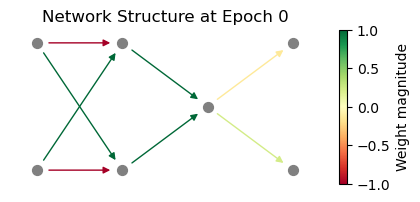

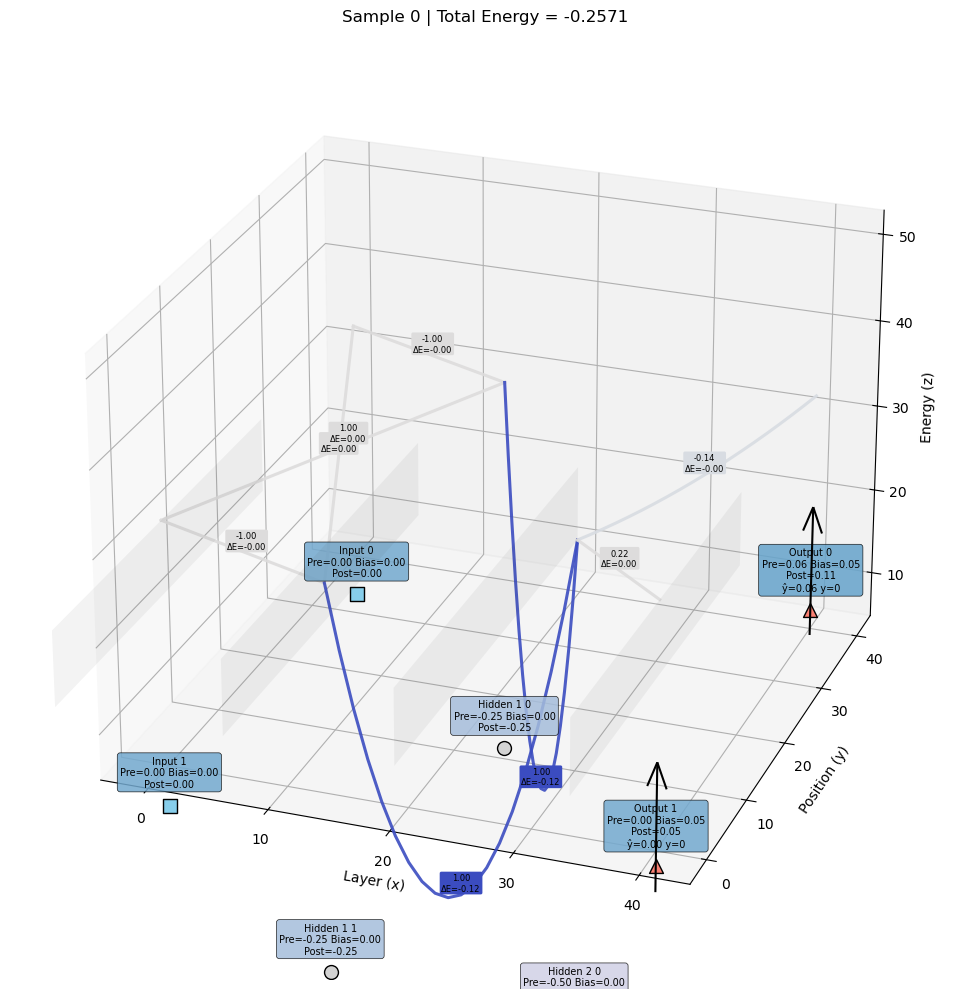

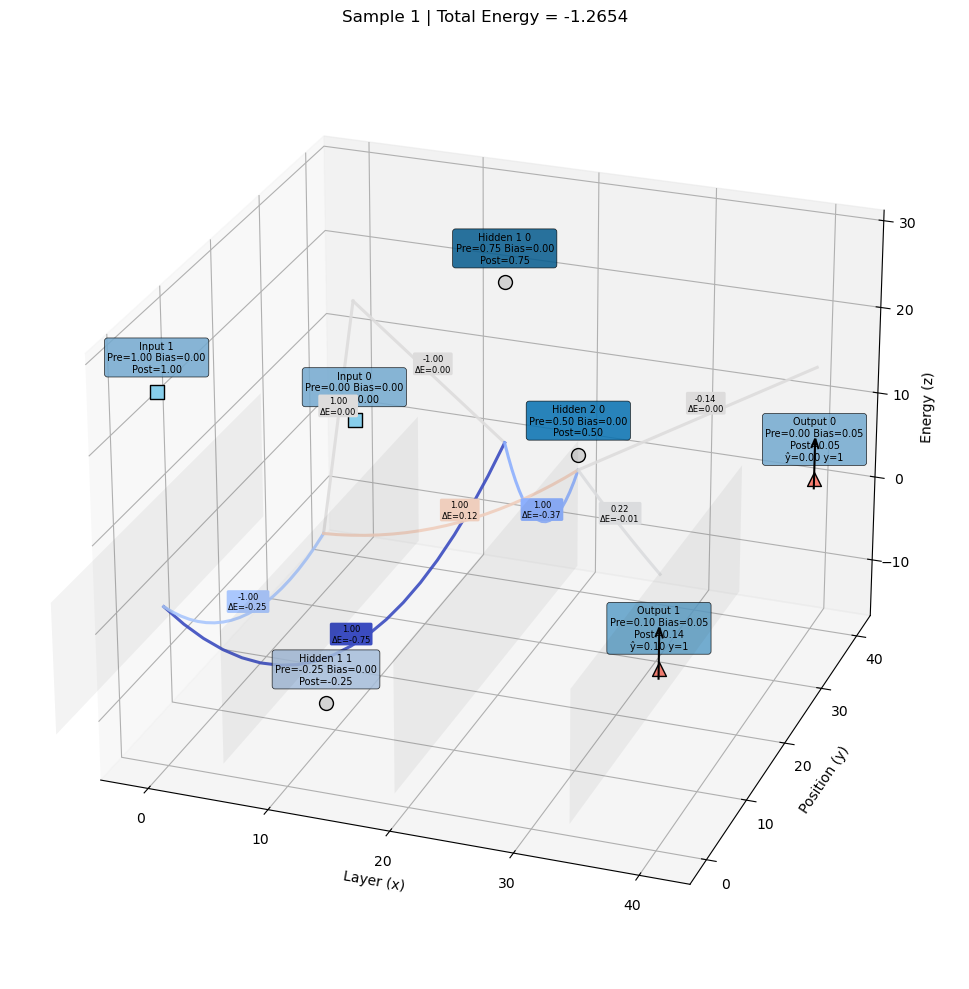

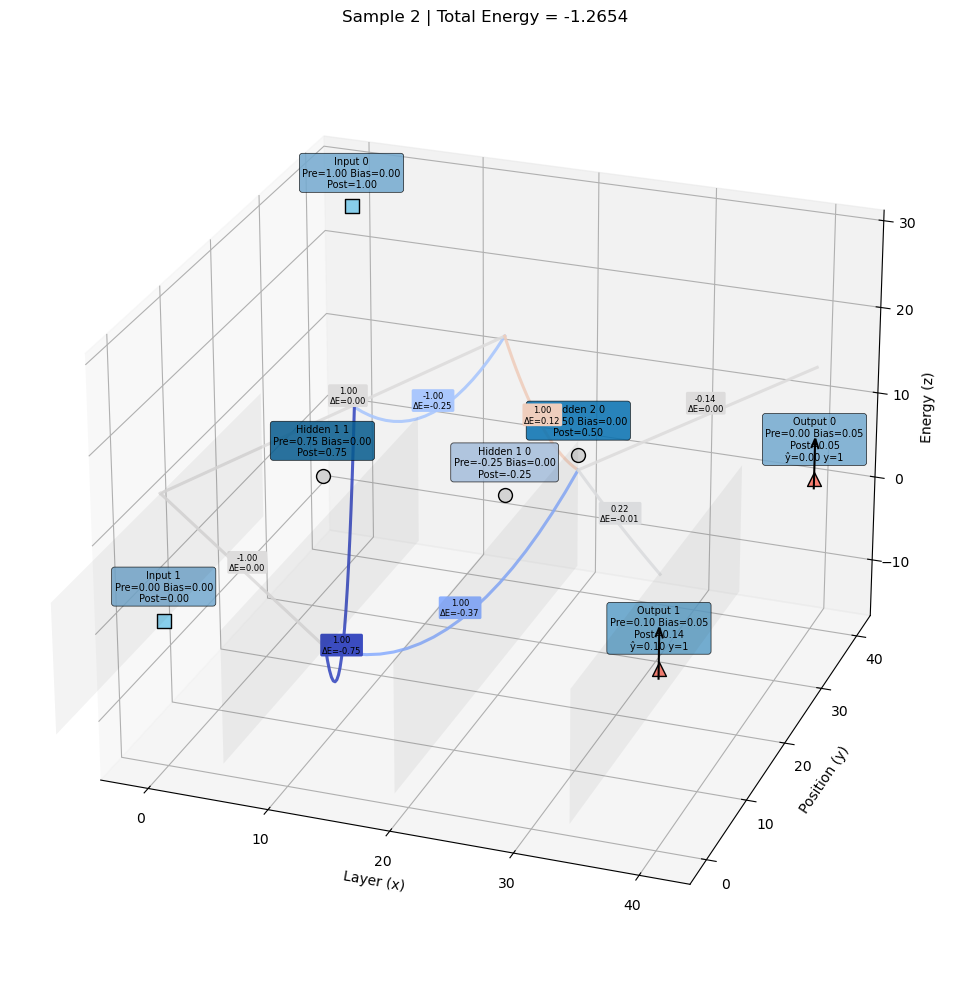

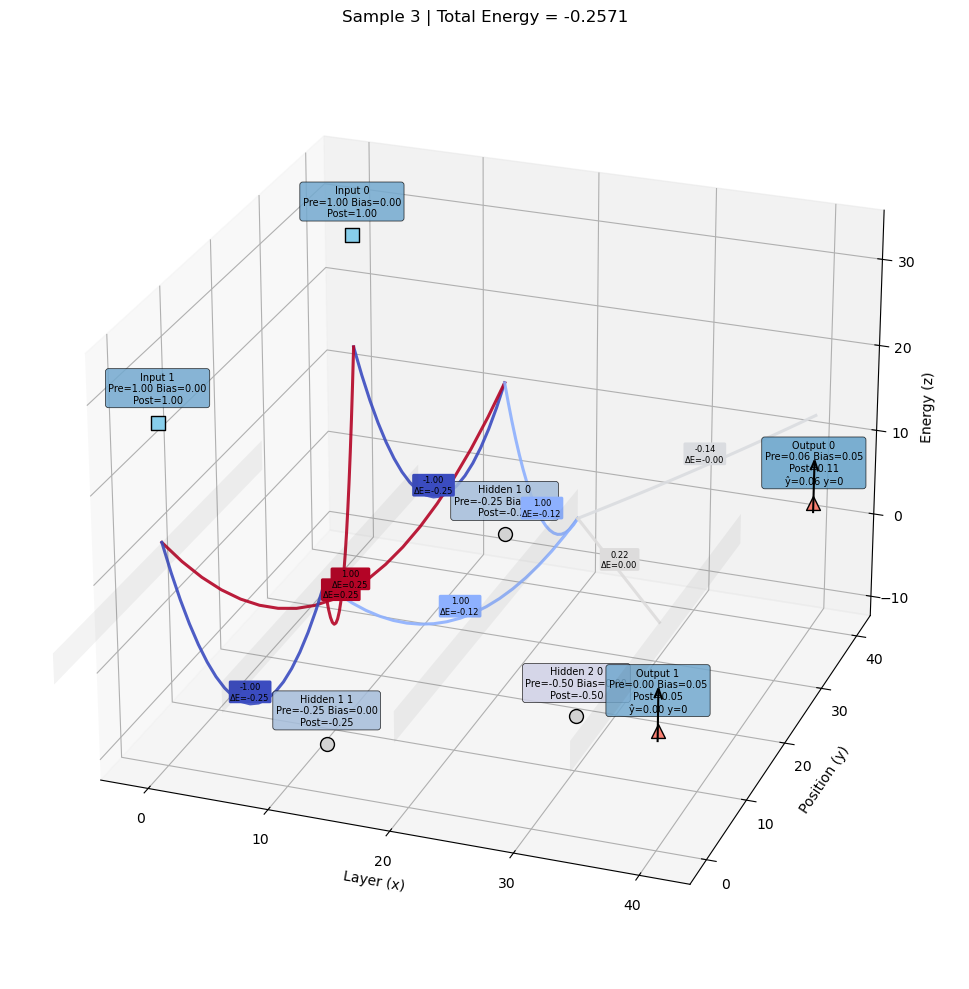

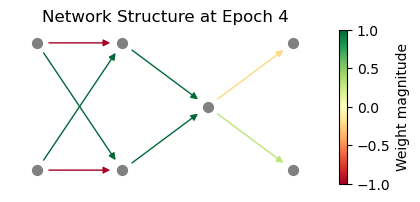

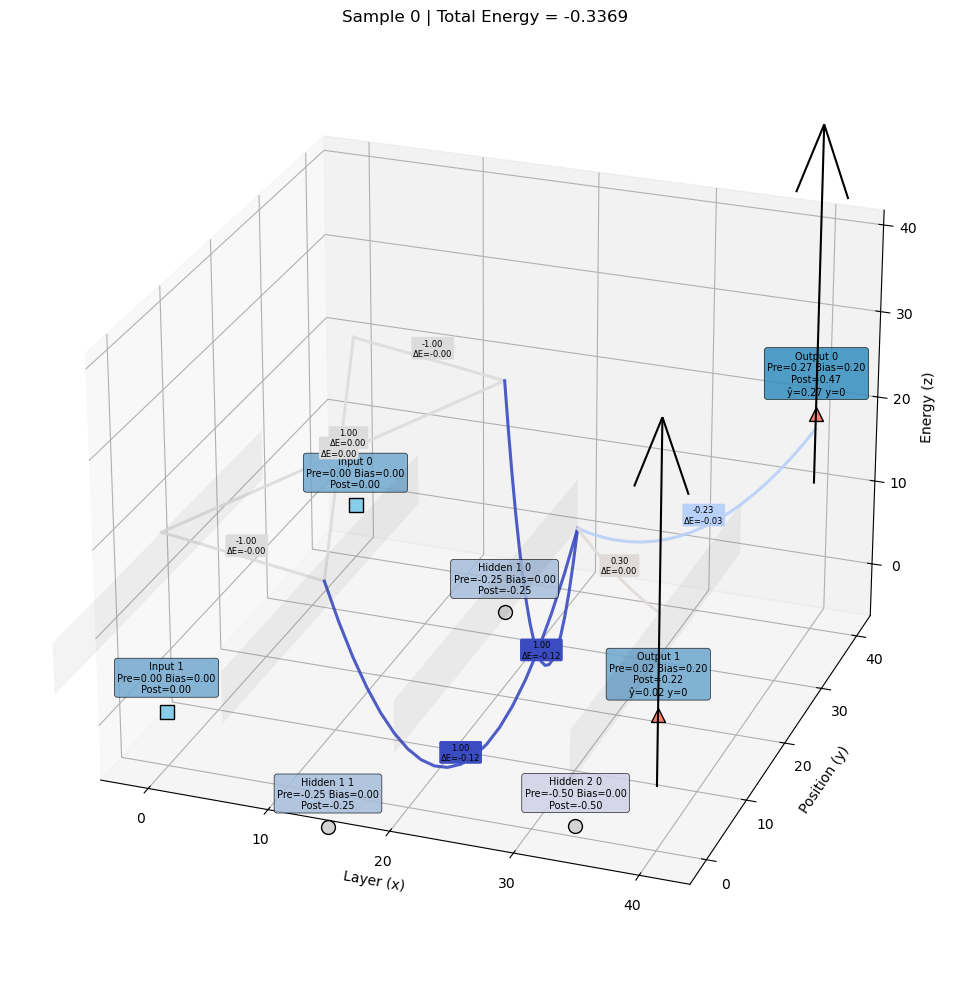

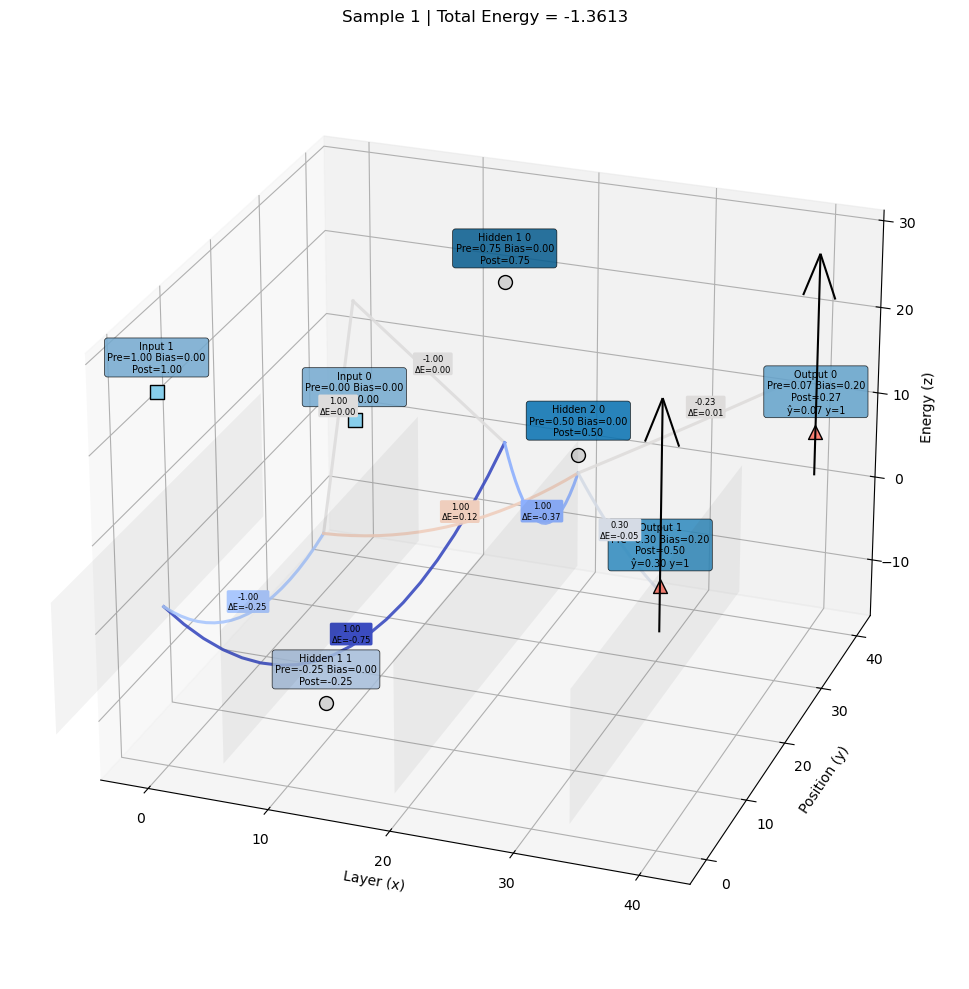

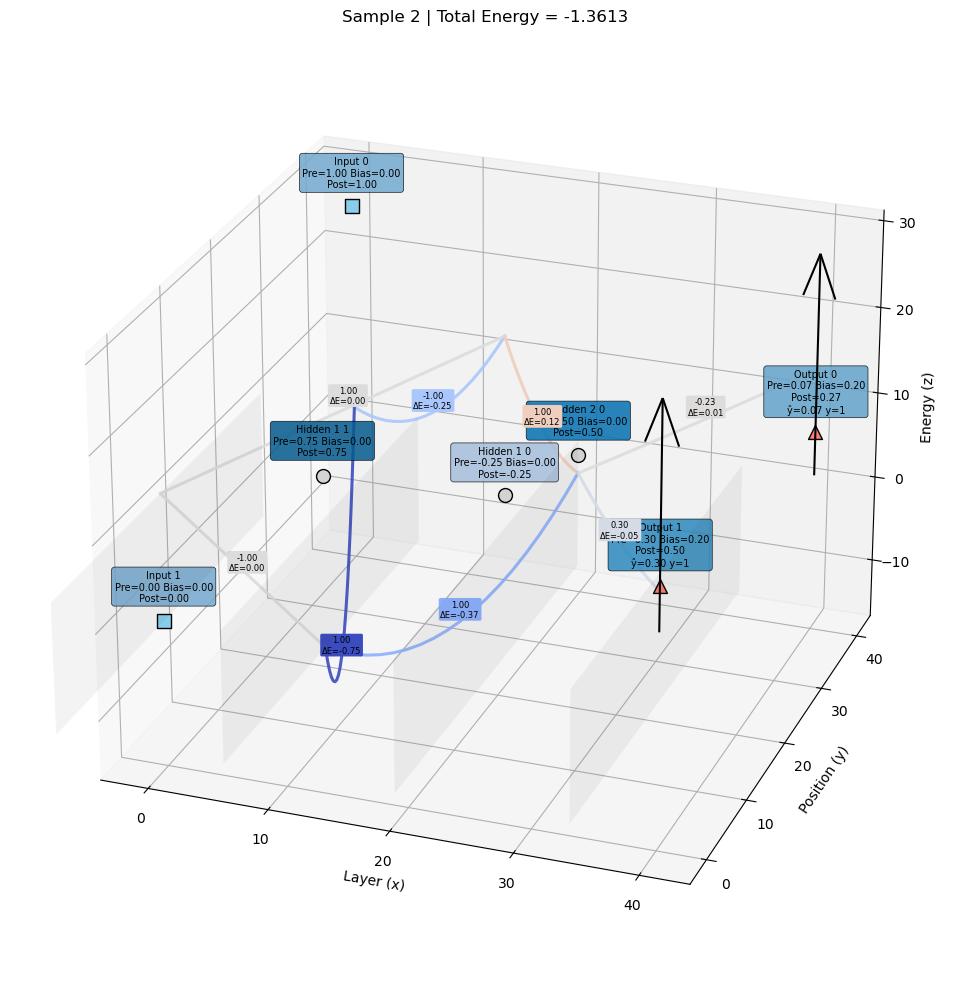

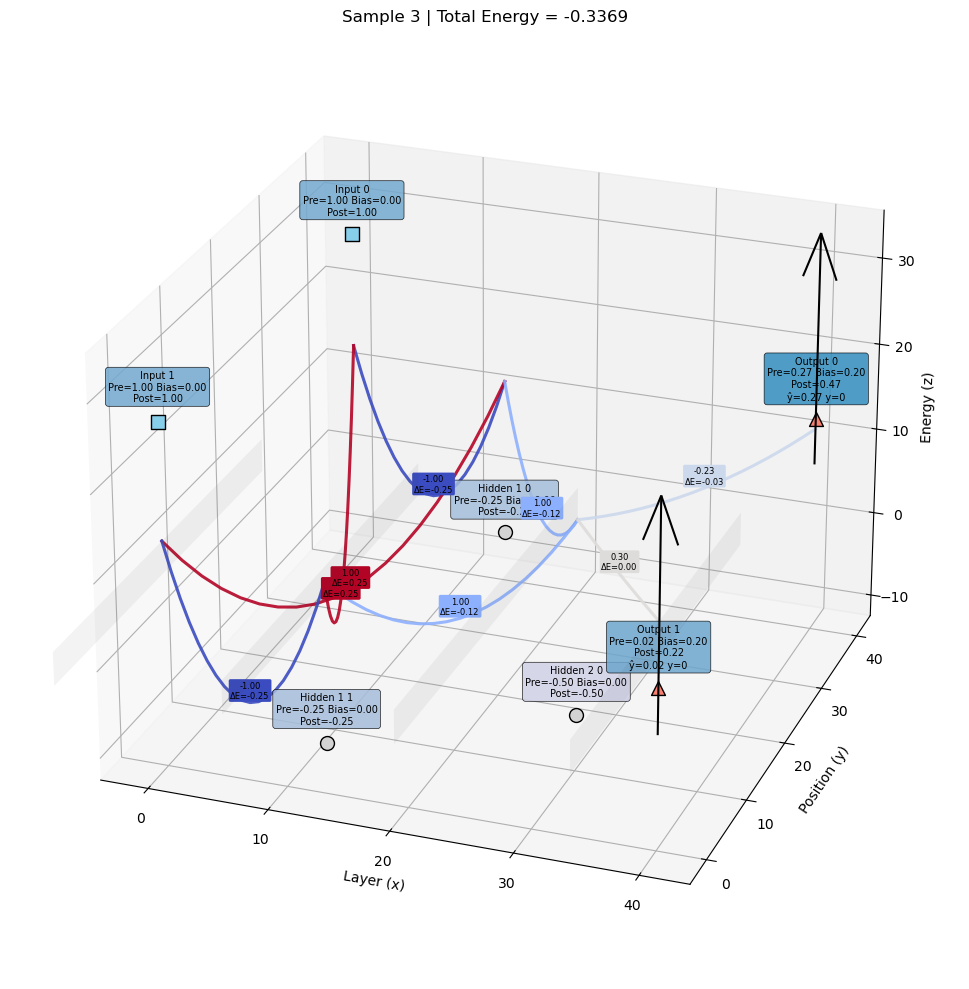

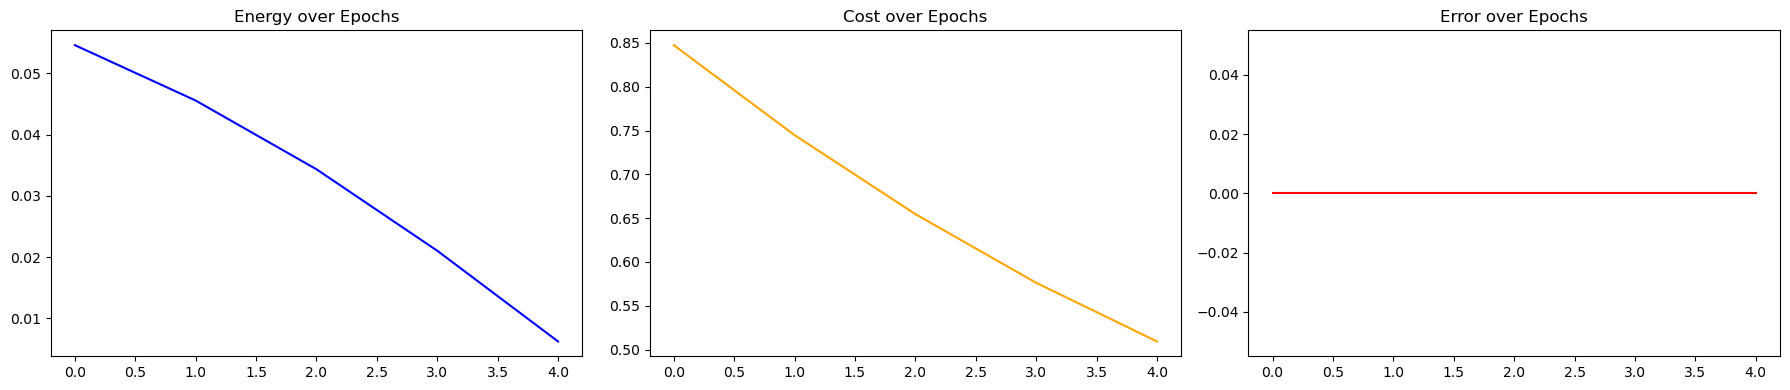

err 0.0
[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.2722, 0.0237],
        [0.0654, 0.3042],
        [0.0654, 0.3042],
        [0.2722, 0.0237]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0.2019, 0.1975])]
[tensor([[-1.,  1.],
        [ 1., -1.]]), tensor([[1.0000],
        [1.0000]]), tensor([[-0.2266,  0.2986]])]
[tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.2722, 0.0237],
        [0.0654, 0.3042],
        [0.0654, 0.3042],
        [0.2722, 0.0237]])]


In [121]:
xor_net = Network(
            name=f"xor_trial",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 5,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1,0.1,0.1],
                             "activation": "relu"
            }
        )

        # Unpack init into weights and biases

init = [-1.   ,      1.   ,      1.    ,    -1.     ,    1.0000024 , 1.0000024]
init = torch.tensor(init, dtype=torch.float32)

with torch.no_grad():
    xor_net.weights[0][:] = init[0:4].reshape(2, 2) #torch.tensor([-1, -0.25, 0.25, 1]).reshape(2, 2)
    xor_net.weights[1][:] = init[4:6].reshape(2, 1)# torch.tensor([-1, 1]).reshape(2, 1)


# Evaluate the net — assume this function exists
print('err', train_net(xor_net, plot_graph= True))
# print("Total layer sum:", sum(l.sum() for l in xor_net.layers).item())
# print("Total weight sum:", sum(w.sum() for w in xor_net.weights).item())
# print("Total bias sum:", sum(b.sum() for b in xor_net.biases).item())

print(xor_net.layers)
print(xor_net.biases)
print(xor_net.weights)
print(xor_net.persistent_particles)


